# TP2 - Détection d'Anomalies (Isolation Forest)

Ce notebook charge les données ECG préparées et applique l'algorithme Isolation Forest pour la détection d'anomalies.

In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, auc
)
import time
import tracemalloc
import warnings
import sys
from pathlib import Path

In [2]:
# --- Configuration des Chemins ---

PROJECT_ROOT = Path("../..").resolve()
DATA_PROCESSED_PATH = PROJECT_ROOT / "data" / "ECG"
PROJECT_FCT = PROJECT_ROOT / "src"
sys.path.append(str(PROJECT_FCT))

print(f"Chemin du projet racine : {PROJECT_ROOT}")
print(f"Chargement des données depuis : {DATA_PROCESSED_PATH}")

Chemin du projet racine : C:\Users\sebdr\OneDrive\Bureau\sherbrooke\IFT 599 - Sciences des données\TP2 Devoir\git
Chargement des données depuis : C:\Users\sebdr\OneDrive\Bureau\sherbrooke\IFT 599 - Sciences des données\TP2 Devoir\git\data\ECG


In [3]:
# --- Chargement des modules locaux ---
try:
    print("Modules locaux chargés.")
except ImportError:
    print("Pas de modules locaux spécifiques trouvés dans /src.")

warnings.filterwarnings('ignore')

Modules locaux chargés.


In [4]:
# --- Chargement des données ---

print("Chargement des données ECG préparées (depuis data/processed/)...")
try:
    X_train_scaled = np.load(DATA_PROCESSED_PATH / 'ecg_X_train_scaled.npy')
    X_val_scaled = np.load(DATA_PROCESSED_PATH / 'ecg_X_val_scaled.npy')
    X_test_scaled = np.load(DATA_PROCESSED_PATH / 'ecg_X_test_scaled.npy')
    y_train = np.load(DATA_PROCESSED_PATH / 'ecg_y_train.npy')
    y_val = np.load(DATA_PROCESSED_PATH / 'ecg_y_val.npy')
    y_test = np.load(DATA_PROCESSED_PATH / 'ecg_y_test.npy')
    
    print(f"Données d'entraînement (normales): {X_train_scaled.shape}")
    print(f"Données de validation (mixtes): {X_val_scaled.shape}")
    print(f"Données de test (mixtes): {X_test_scaled.shape}")

except FileNotFoundError:
    print(f"ERREUR: Fichiers non trouvés dans {DATA_PROCESSED_PATH}")
    print("Veuillez d'abord exécuter le notebook 'PreparationData.ipynb'.")

Chargement des données ECG préparées (depuis data/processed/)...
Données d'entraînement (normales): (1247, 140)
Données de validation (mixtes): (791, 140)
Données de test (mixtes): (2960, 140)


# 1. Recherche de la contamination optimale (Validation)

Cette étape peut être faite une seule fois ou dans la boucle. Pour gagner du temps, on fixe l'hyperparamètre ici, puis on teste la variabilité de l'entraînement ensuite.

In [5]:
print("Recherche du seuil (contamination) optimal...")
contaminations = np.linspace(0.01, 0.2, 20) # Plage réduite pour l'exemple
f1_scores_if = []

for cont in contaminations:
    # On utilise une seed fixe ici juste pour trouver l'hyperparamètre
    model_if_val = IsolationForest(contamination=cont, random_state=42)
    model_if_val.fit(X_train_scaled)
    
    scores_if_val = model_if_val.decision_function(X_val_scaled)
    seuil_if = np.quantile(scores_if_val, cont)
    y_pred_if_val = np.where(scores_if_val <= seuil_if, 1, 0)
    
    f1_scores_if.append(f1_score(y_val, y_pred_if_val, pos_label=1))

CONTAMINATION_OPTIMALE_IF = contaminations[np.argmax(f1_scores_if)]
print(f"Contamination optimale (Val): {CONTAMINATION_OPTIMALE_IF:.4f}")

Recherche du seuil (contamination) optimal...
Contamination optimale (Val): 0.2000


# 2. Protocole Expérimental (10 Exécutions sur Test)

In [6]:
print("--- Lancement du protocole expérimental (10 exécutions) ---")

N_RUNS = 10
results_if = []

# Pour sauvegarder le dernier modèle pour les graphiques
last_model_if = None
last_y_pred_if = None
last_scores_if = None

for i in range(N_RUNS):
    print(f"Exécution {i+1}/{N_RUNS}...", end="\r")
    current_seed = i
    
    # --- Mesure Computationnelle : Début ---
    tracemalloc.start()
    start_time = time.time()
    
    # 1. Entraînement
    model_if = IsolationForest(contamination=CONTAMINATION_OPTIMALE_IF, random_state=current_seed)
    model_if.fit(X_train_scaled)
    
    # --- Mesure Computationnelle : Fin ---
    end_time = time.time()
    current_mem, peak_mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    # 2. Prédiction sur Test
    # Isolation Forest renvoie -1 pour anomalie, 1 pour normal
    y_pred_raw = model_if.predict(X_test_scaled)
    y_pred = np.where(y_pred_raw == -1, 1, 0) # Convertir en 1=Anomalie, 0=Normal
    
    # Scores pour ROC-AUC (-decision_function pour avoir plus grand = plus anormal)
    scores = -model_if.decision_function(X_test_scaled)
    
    # 3. Calcul des métriques
    metrics_run = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred, pos_label=1),
        'Precision': precision_score(y_test, y_pred, pos_label=1),
        'F1-Score': f1_score(y_test, y_pred, pos_label=1),
        'ROC-AUC': roc_auc_score(y_test, scores),
        'Time (s)': end_time - start_time,
        'Memory (MB)': peak_mem / (1024 ** 2)
    }
    results_if.append(metrics_run)
    
    # Sauvegarde pour viz
    last_model_if = model_if
    last_y_pred_if = y_pred
    last_scores_if = scores

print(f"\nProtocole terminé.")

--- Lancement du protocole expérimental (10 exécutions) ---
Exécution 10/10...
Protocole terminé.


In [7]:
# --- Analyse des Résultats ---
df_results_if = pd.DataFrame(results_if)
mean_if = df_results_if.mean()
std_if = df_results_if.std()

print("\n--- Résultats Isolation Forest (μ ± σ sur 10 exécutions) ---")
for metric in df_results_if.columns:
    print(f"{metric:<15}: {mean_if[metric]:.4f} ± {std_if[metric]:.4f}")


--- Résultats Isolation Forest (μ ± σ sur 10 exécutions) ---
Accuracy       : 0.9545 ± 0.0007
Recall         : 0.9994 ± 0.0004
Precision      : 0.9460 ± 0.0009
F1-Score       : 0.9720 ± 0.0004
ROC-AUC        : 0.9332 ± 0.0072
Time (s)       : 0.8268 ± 0.0207
Memory (MB)    : 1.3038 ± 0.0061


# 3. Visualisations (Sur la dernière exécution)

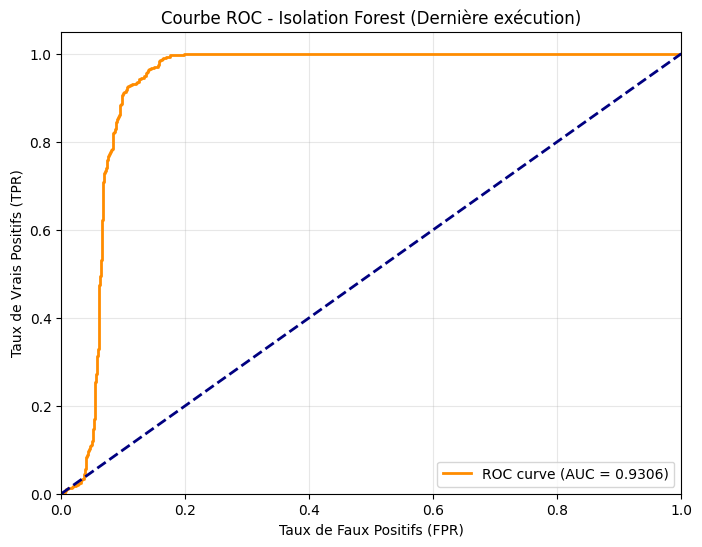

In [8]:
# --- Courbe ROC ---
fpr, tpr, _ = roc_curve(y_test, last_scores_if)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC - Isolation Forest (Dernière exécution)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

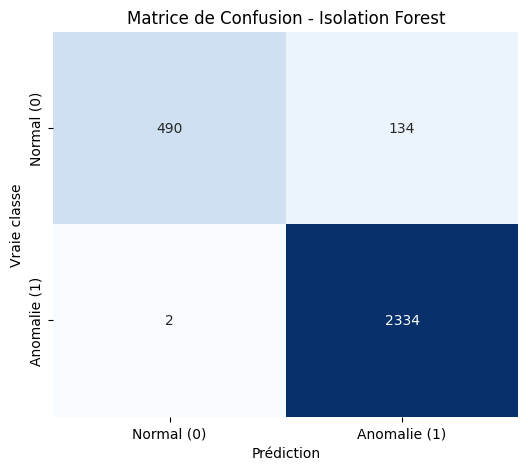

In [9]:
# --- Matrice de Confusion ---
cm = confusion_matrix(y_test, last_y_pred_if)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal (0)', 'Anomalie (1)'],
            yticklabels=['Normal (0)', 'Anomalie (1)'])
plt.xlabel('Prédiction')
plt.ylabel('Vraie classe')
plt.title('Matrice de Confusion - Isolation Forest')
plt.show()